In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, Image as IPImage

from PIL import Image

from ipywidgets import interact, Dropdown, IntText

import cv2
from skimage import feature
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import numpy as np

from MirrorExtractor.mirror_extractor import MirrorExtractor

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest

In [15]:
class MirrorFeatureExtractor:
    """Extracts features from mirror images"""
    
    @staticmethod
    def extract_all_features(mirror_img):
        """
        Extract all features from a single mirror image
        
        Args:
            mirror_img: numpy array of shape (H, W, 3)
            
        Returns:
            dict: Dictionary of feature name -> feature value
        """
        features = {}
        
        # Brightness features
        features['brightness_mean'] = np.mean(mirror_img)
        features['brightness_std'] = np.std(mirror_img)
        features['brightness_min'] = np.min(mirror_img)
        features['brightness_max'] = np.max(mirror_img)
        
        # Channel-specific features
       # for i, channel in enumerate(['R', 'G', 'B']):
       #     features[f'{channel}_mean'] = np.mean(mirror_img[:, :, i])
       #     features[f'{channel}_std'] = np.std(mirror_img[:, :, i])
        
        # Statistical features
        features['skewness'] = skew(mirror_img.flatten())
        features['kurtosis'] = kurtosis(mirror_img.flatten())
        
        # Texture features (if you want to add them later)
        # gray = cv2.cvtColor(mirror_img, cv2.COLOR_RGB2GRAY)
        # features['entropy'] = -np.sum(gray * np.log2(gray + 1e-10))
        
        return features

class MirrorAnomalyDetector:
    """Detects anomalies in mirror images"""
    
    def __init__(self, extractor, feature_extractor=None, contamination=0.1):
        """
        Args:
            extractor: MirrorExtractor instance
            feature_extractor: MirrorFeatureExtractor instance
            contamination: Expected proportion of outliers (for IsolationForest)
        """
        self.extractor = extractor
        self.feature_extractor = feature_extractor or MirrorFeatureExtractor()
        self.contamination = contamination
        
        # Storage for baseline models
        self.baseline_stats = {}  # Statistical baseline (mean, std)
        self.ml_models = {}       # ML models (IsolationForest)
        self.scalers = {}         # Feature scalers
        self.feature_names = None

    def extract_mirror_from_image(self, img_path, mirror_id):
        """Extract a single mirror from an image"""
        img = np.array(Image.open(img_path).convert('RGB'))
        x_coords, y_coords = self.extractor.get_coords(mirror_id)
        cropped = self.extractor.extract_polygon_region_cv2(img, x_coords, y_coords)
        return cropped

    def extract_features_from_images(self, img_path_list, mirror_id):
        """
        Extract features from multiple images for a specific mirror
        
        Returns:
            pandas DataFrame with features
        """
        features_list = []
        
        for img_path in img_path_list:
            mirror_img = self.extract_mirror_from_image(img_path, mirror_id)
            features = self.feature_extractor.extract_all_features(mirror_img)
            features_list.append(features)
        
        df = pd.DataFrame(features_list)
        return df

    def build_baseline(self, img_path_list, mirror_id_list):
        """
        Build baseline models for multiple mirrors
        
        Args:
            img_path_list: List of image paths for training
            mirror_id_list: List of mirror IDs to create baselines for
        """
        print(f"Building baseline from {len(img_path_list)} images...")
        
        for mirror_id in mirror_id_list:
            print(f"Processing mirror {mirror_id}...")
            
            # Extract features
            features_df = self.extract_features_from_images(img_path_list, mirror_id)
            
            if self.feature_names is None:
                self.feature_names = features_df.columns.tolist()
            
            # Statistical baseline
            self.baseline_stats[mirror_id] = {
                'mean': features_df.mean().to_dict(),
                'std': features_df.std().to_dict(),
                'min': features_df.min().to_dict(),
                'max': features_df.max().to_dict(),
                'percentile_95': features_df.quantile(0.95).to_dict(),
                'percentile_5': features_df.quantile(0.05).to_dict(),
            }
            
            # ML-based baseline (Isolation Forest)
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(features_df)
            
            iso_forest = IsolationForest(
                contamination=self.contamination,
                random_state=42,
                n_estimators=100
            )
            iso_forest.fit(features_scaled)
            
            self.scalers[mirror_id] = scaler
            self.ml_models[mirror_id] = iso_forest
            
        print("Baseline building complete!")

    def detect_anomaly_statistical(self, features, mirror_id, n_std=3):
        """
        Detect anomaly using statistical method (mean ± n*std)
        
        Returns:
            dict: Anomaly results
        """
        baseline = self.baseline_stats[mirror_id]
        anomalies = {}
        
        for feature_name, value in features.items():
            mean = baseline['mean'][feature_name]
            std = baseline['std'][feature_name]
            
            # Check if value is outside n standard deviations
            lower_bound = mean - n_std * std
            upper_bound = mean + n_std * std
            
            is_anomaly = value < lower_bound or value > upper_bound
            
            anomalies[feature_name] = {
                'value': value,
                'mean': mean,
                'std': std,
                'is_anomaly': is_anomaly,
                'z_score': (value - mean) / (std + 1e-10),
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
        
        # Overall anomaly decision
        num_anomalies = sum(1 for v in anomalies.values() if v['is_anomaly'])
        is_overall_anomaly = num_anomalies > 0
        
        return {
            'is_anomaly': is_overall_anomaly,
            'num_anomalous_features': num_anomalies,
            'total_features': len(features),
            'feature_details': anomalies
        }

    def detect_anomaly_with_stats(self, img_path, mirror_id, n_std=3):
        """
        Detect anomaly in a new image
        
        Args:
            img_path: Path to the image
            mirror_id: Mirror ID to check
            method: 'statistical', 'ml', or 'both'
            n_std: Number of standard deviations for statistical method
            
        Returns:
            dict: Complete anomaly detection results
        """
        # Extract mirror and features
        mirror_img = self.extract_mirror_from_image(img_path, mirror_id)
        features = self.feature_extractor.extract_all_features(mirror_img)
        
        results = {
            'mirror_id': mirror_id,
            'image_path': img_path,
            'features': features
        }
        
        # Statistical detection
        results['statistical'] = self.detect_anomaly_statistical(
                features, mirror_id, n_std
            )
        return results 

In [16]:
def show_mirror_on_img(mirror_id, img_path):
    x_coords, y_coords = extractor.get_coords(mirror_id)
    img_np = np.array(Image.open(img_path).convert('RGB'))
    fig, ax1 = plt.subplots()
    ax1.imshow(img_np)
    ax1.plot(x_coords, y_coords, 'r-', lw=2)
    ax1.scatter(x_coords[:-1], y_coords[:-1], c='cyan', s=30)
    plt.show()

In [17]:
# Initialize
extractor = MirrorExtractor(
    "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/crossings_points.pkl"
)
detector = MirrorAnomalyDetector(extractor, contamination=0.05)
    
# Get training images
img_list = glob.glob(
    "/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/*.jpg"
)
print(f"Found {len(img_list)} training images")

Found 380 training images


In [18]:
# Define mirrors to monitor
mirror_id_list = [15, 50, 100]
    
# Build baseline (use subset for faster testing)
detector.build_baseline(img_list[:100], mirror_id_list)  # Use more images in production

Building baseline from 100 images...
Processing mirror 15...
Processing mirror 50...
Processing mirror 100...
Baseline building complete!


In [19]:
# Test on new image
new_image_path = '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg'
    
for mirror_id in mirror_id_list:
    results = detector.detect_anomaly_with_stats(
        new_image_path, 
        mirror_id, 
        n_std=2  # Adjust sensitivity (lower = more sensitive)
    )

In [20]:
mirror_id_list


[15, 50, 100]

In [21]:
results.keys()

dict_keys(['mirror_id', 'image_path', 'features', 'statistical'])

In [22]:
results

{'mirror_id': 100,
 'image_path': '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg',
 'features': {'brightness_mean': np.float64(73.15789473684211),
  'brightness_std': np.float64(55.26387438721731),
  'brightness_min': np.uint8(0),
  'brightness_max': np.uint8(255),
  'skewness': np.float64(0.40821644369227406),
  'kurtosis': np.float64(0.3541626466324401)},
 'statistical': {'is_anomaly': False,
  'num_anomalous_features': 0,
  'total_features': 6,
  'feature_details': {'brightness_mean': {'value': np.float64(73.15789473684211),
    'mean': 77.8688338493292,
    'std': 15.36782103753858,
    'is_anomaly': np.False_,
    'z_score': np.float64(-0.30654567755240986),
    'lower_bound': 47.13319177425205,
    'upper_bound': 108.60447592440636},
   'brightness_std': {'value': np.float64(55.26387438721731),
    'mean': 57.38667729364559,
    'std': 10.807415159311839,
    'is_anomaly': np.False_,
    'z_score': np.float64

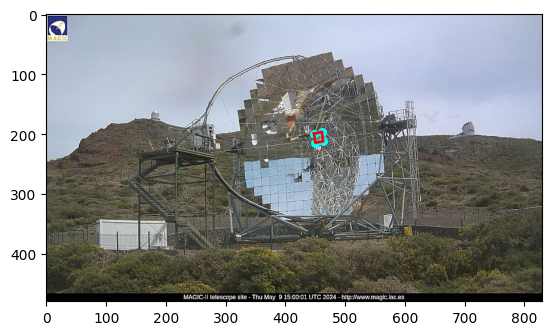

In [23]:
show_mirror_on_img(145, new_image_path)

# My solution

In [2]:
def show_image(image_path, mirror_id):
    img = Image.open(image_path)
    x_coords, y_coords = extractor.get_coords(mirror_id)
    
    plt.figure(figsize=(10, 8))
    plt.plot(x_coords, y_coords, 'r-', lw=2)
    plt.scatter(x_coords[:-1], y_coords[:-1], c='cyan', s=30)
    plt.imshow(img)
    plt.axis('off')
    text_title = image_path.split('/')[-1] + "mirror id:" + str(mirror_id)
    plt.title(text_title)
    plt.show()

def extract_one_mirror_from_images(img_path_list, mirror_id, extractor):
    mirror_list = []
    for path in img_path_list:
        img = np.array(Image.open(path).convert('RGB'))
        x_coords, y_coords = extractor.get_coords(mirror_id)
        cropped = extractor.extract_polygon_region_cv2(img, x_coords, y_coords)
        mirror_list.append(cropped)
    return mirror_list

def get_one_mirror_features(mirror_img):
    brightness = np.mean(mirror)
    brightness_std = np.std(mirror)
    return brightness
    
def compute_mirror_features(mirror_list):
    """
    Oblicza cechy dla każdego lustra
    """
    features_dict = {}
    brightness_list = []
    brightness_std_list = []
    
    
    for mirror in mirror_list:
        brightness_list.append(np.mean(mirror))
        brightness_std_list.append(np.std(mirror))
    
    features_dict["brightness"] = brightness_list
    features_dict["brightness_std"] = brightness_std_list
    return features_dict

## 1. Build base model with good images

In [3]:
extractor = MirrorExtractor("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/crossings_points.pkl")

In [4]:
img_list = glob.glob("/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/*.jpg")
print(img_list[:5])
mirror_list_150 = extract_one_mirror_from_images(img_list[:], 150, extractor)
mirror_list_50 = extract_one_mirror_from_images(img_list[:], 50, extractor)

['/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2023-01-04_1600.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-07_1600.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-04_1000.jpg', '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-21_1700.jpg']


In [5]:
features_150 = compute_mirror_features(mirror_list_150)

In [6]:
features_150.keys()

dict_keys(['brightness', 'brightness_std'])

In [29]:
mirror_id_list = [15, 50, 100]
mirror_feature_list = []
mirror_base_model_dict = {}

for mirror_id in mirror_id_list:
    print(mirror_id)
    mirrors_list = extract_one_mirror_from_images(img_list[:], mirror_id, extractor)
    feature_mirror = compute_mirror_features(mirrors_list)
    mirror_feature_list.append(feature_mirror)
    mirror_base_model_dict[f'id_{mirror_id}'] = {'mean_brightness':np.mean(feature_mirror["brightness"]), 
                                                 'mean_std_brightness':np.mean(feature_mirror["brightness_std"])}
    

15
50
100


In [30]:
mirror_base_model_dict


{'id_15': {'mean_brightness': np.float64(119.14611713106295),
  'mean_std_brightness': np.float64(84.39408997511109)},
 'id_50': {'mean_brightness': np.float64(116.54099136730717),
  'mean_std_brightness': np.float64(87.22786908682455)},
 'id_100': {'mean_brightness': np.float64(77.49262940633318),
  'mean_std_brightness': np.float64(56.84909484092278)}}

# Test on new image

In [43]:
new_image_path = '/home/pgliwny/Praca/Computer_vision_for_MAGIC/data/webcam_useful_image/webcam_useful_images/image_2024-05-09_1500.jpg'
mirror_id_list = [15, 50, 100]
new_img_list = [new_image_path]
for mirror_id in mirror_id_list:
    print(mirror_id)
    mirror = extract_one_mirror_from_images(new_img_list[:], mirror_id, extractor)
    brightness = np.mean(mirror)
    brightness_std = np.std(mirror)
    if brightness > mirror_base_model_dict[f"id_{mirror_id}"]["mean_brightness"]:
        print("Annomarly")

15
Annomarly
50
Annomarly
100


In [17]:
mirror_status = np.ones(289)